### Project Adressing the balancing strategies for unbalance ds 
### DATA: HAMD1000
#### Notebook #1 -> evaluation of the ds -> vizualization of how unbalance the ds. 

In [ ]:
import random
import numpy as np
import torch 

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True

### Loading the data 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
import shutil

In [ ]:
from google.colab import drive
#drive.mount('content/drive/My_Drive/Colab_Notebook')
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive/Colab Notebooks'

/content/drive/My Drive/Colab Notebooks


In [ ]:
!pwd

/content/drive/My Drive/Colab Notebooks


In [ ]:
df = pd.read_csv('Dermatology dataset/HAM10000_metadata')

In [ ]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [ ]:
import seaborn as sns

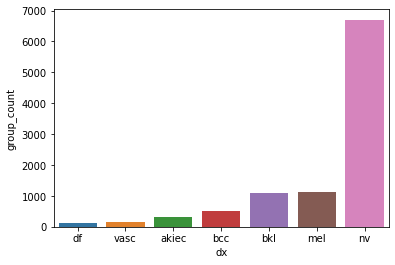

In [ ]:
# raw data distribution 
sns.barplot(x='dx', y = 'group_count', data= df.groupby('dx').size().reset_index(name='group_count').sort_values(by = 'group_count'))

In [ ]:
df = df.drop_duplicates(subset=["lesion_id"])
df.size

67230

### Descriptive stats 

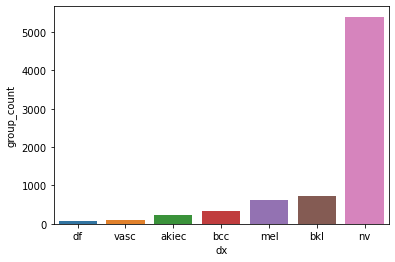

In [ ]:
sns.barplot(x='dx', y = 'group_count', data= df.groupby('dx').size().reset_index(name='group_count').sort_values(by = 'group_count'))

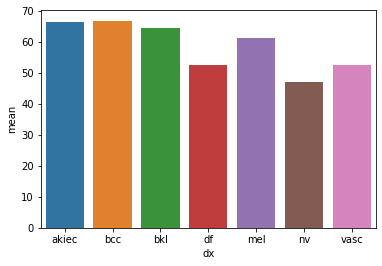

In [ ]:
age = df.groupby('dx').age.agg(['mean', 'max', 'min']).reset_index()
sns.barplot(x='dx', y='mean', data=age)
#### we have 0 ages values in the dataframe 

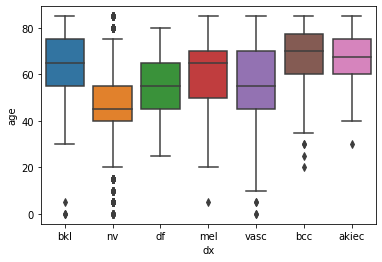

In [ ]:
sns.boxplot(x='dx', y='age', data=df)

In [ ]:
import seaborn as sns

In [ ]:
gender = df.groupby(['dx', 'sex']).size().reset_index().rename(columns ={0 : 'count'})
type(gender)

pandas.core.frame.DataFrame

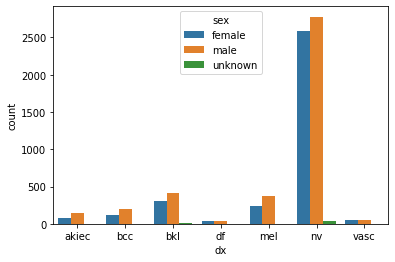

In [ ]:
sns.barplot(x="dx",
 y='count', 
 hue="sex", 
 data=gender)

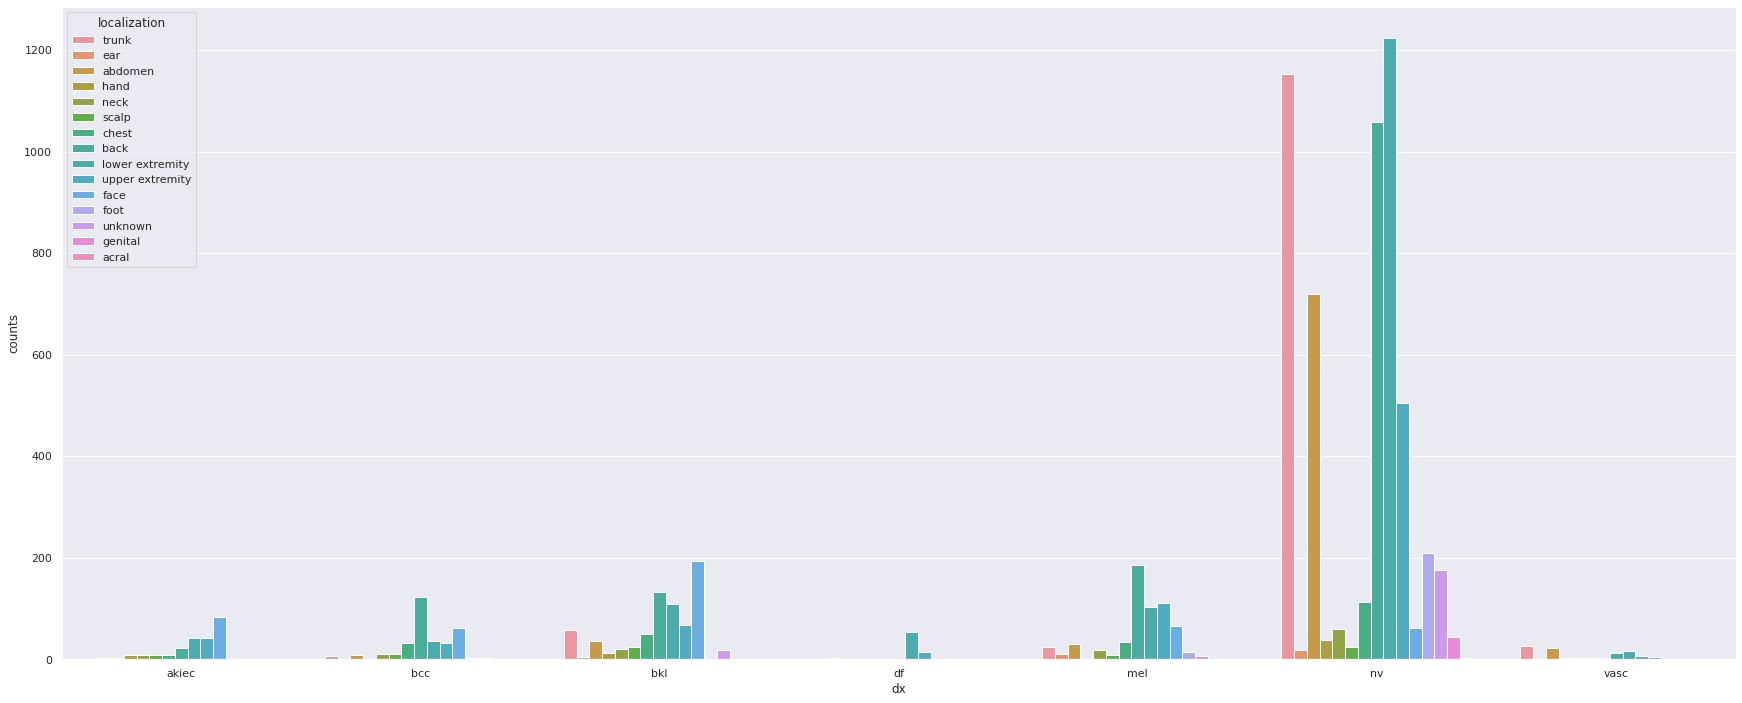

In [ ]:
sns.set(rc={'figure.figsize':(30, 12)})
localization = df.groupby(['dx', 'localization']).size().reset_index(name = "counts").sort_values(by = ['dx','counts'])
sns.barplot(x = 'dx', y = 'counts', hue = 'localization',data = localization)


In [ ]:
df.describe()

,age,label
count,7418.000000,7470.000000
mean,51.658803,4.291700
std,16.016472,1.404399
min,0.000000,0.000000
25%,40.000000,4.000000
50%,50.000000,5.000000
75%,65.000000,5.000000
max,85.000000,6.000000


In [ ]:
df.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             52
sex              0
localization     0
dataset          0
label            0
dtype: int64

### Loading the dataset 

In [ ]:
from torchvision import datasets #import ImageFolder
from torchvision import transforms #import ToTensor
from torch import nn
import torch
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, utils, models
from torch import optim
from torchvision.models import DenseNet

In [ ]:
path = os.getcwd() + '/Dermatology dataset'

In [ ]:
dataset = datasets.ImageFolder(path)

In [ ]:
dataset.classes

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [ ]:
dataset 

Dataset ImageFolder
    Number of datapoints: 10015
    Root location: /content/drive/MyDrive/Colab Notebooks/Dermatology dataset

In [ ]:
dataset[1][0].size # size of image 

(600, 450)

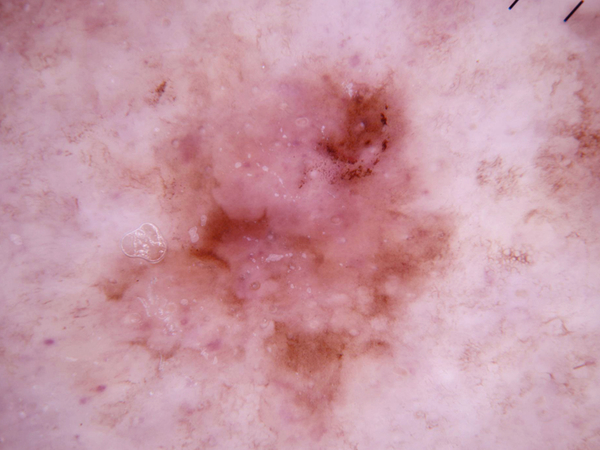

In [ ]:
dataset[1][0]

In [ ]:
2* (len(dataset) *0.20) + (len(dataset)*0.60) == len(dataset)

True

In [ ]:
# transformation of the datasets
transform = transforms.Compose([ transforms.Resize((255, 255)),
                            transforms.RandomRotation(25), 
                            transforms.RandomCrop(220),
                      
                      #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
                              transforms.RandomHorizontalFlip(),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                              ])

transNoAugment = transforms.Compose([
                                  transforms.Resize((255,255)) ,  
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                 ])

In [ ]:
# calculating the class weight for the targets 
# I am going to use the metadata datset -> since it is easier 
labels = df.dx.unique().tolist()
labels

['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']

In [ ]:
import sklearn

from sklearn.preprocessing import LabelEncoder

# label encoding to numeric values from text
le = LabelEncoder()
le.fit(df['dx'])
LabelEncoder()
print(list(le.classes_))
 
df['label'] = le.transform(df["dx"]) 
print(df.sample(10))


['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx  ...     localization        dataset label
1617  HAM_0007180  ISIC_0033272  mel  ...             face   vidir_modern     4
8128  HAM_0007195  ISIC_0031923   nv  ...  lower extremity    vienna_dias     5
2168  HAM_0001835  ISIC_0026652  mel  ...             back      rosendahl     4
1090  HAM_0000465  ISIC_0030583  bkl  ...            trunk  vidir_molemax     2
7754  HAM_0001720  ISIC_0034010   nv  ...          abdomen   vidir_modern     5
8071  HAM_0006333  ISIC_0024424   nv  ...            trunk    vienna_dias     5
7423  HAM_0004548  ISIC_0032832   nv  ...  upper extremity   vidir_modern     5
8984  HAM_0006526  ISIC_0026671   nv  ...  lower extremity      rosendahl     5
2310  HAM_0003102  ISIC_0032389  mel  ...             face      rosendahl     4
7256  HAM_0004260  ISIC_0025525   nv  ...             back   vidir_modern     5

[10 rows x 9 columns]


In [ ]:
list(zip(list(le.classes_) , list(range(7))))

[('akiec', 0),
 ('bcc', 1),
 ('bkl', 2),
 ('df', 3),
 ('mel', 4),
 ('nv', 5),
 ('vasc', 6)]

In [ ]:
class_sample_count = np.array(
    [len(np.where(df.dx == t)[0]) for t in np.unique(df.dx)])

In [ ]:
class_sample_count

array([ 327,  514, 1099,  115, 1113, 6705,  142])

In [ ]:
weight = 1. / class_sample_count
#samples_weight = np.array([weight[t] for t in df.dx])
weight

array([0.0030581 , 0.00194553, 0.00090992, 0.00869565, 0.00089847,
       0.00014914, 0.00704225])

In [ ]:
samples_weight=np.array([weight[t] for t in df.label])
samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()

In [ ]:
len(samples_weight)

10015